In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import string

# Webscrapping Imports
from bs4 import BeautifulSoup       
import regex as re

# NLP Imports
from spellchecker import SpellChecker
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud, ImageColorGenerator
import nltk

# Modelling Imports
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ignore warnings
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

#Stylistic Choice:
plt.style.use('bmh')
sns.set_palette("RdBu_r")

In [2]:
#loading in data sets
train = pd.read_csv('train.csv')
pd.set_option('display.max_colwidth', None)

In [3]:
train = train.drop(['label','text_length'], axis=1)

In [4]:
train.reset_index(drop=True, inplace=True)

In [5]:
train

,text,real_review
0,nice fast delivery the material of the bag is kind of soft but having nice feeling love it,1
1,ok absorb but not totally dry,1
2,dishonest seller bought 6 pcs of masks and 1 pcs strip came off contacted seller and agreed to issue me a 390 discount code for a new order was scammed after they received my preious order payment then canceled my new order so ridiculous asked me to reorder 1 pcs then they will send me 2,0
3,super fast delivery good price for great product,1
4,responsive seller and good product delivery a bit slow may consider change to other logistics provider,1
...,...,...
995,fast delivery looks nice nice packaging received the product in a box within a larger box,0
996,fast delivery ordered on 2152020 n received on 2652020,0
997,received with thanks,0
998,very prompt delivery and response items neatly and hygienically packed inappropriate zipbloc my first time ordering,0


In [6]:
train.isnull().sum()

text           0
real_review    0
dtype: int64

In [7]:
train['real_review'].value_counts()

1    653
0    347
Name: real_review, dtype: int64

In [9]:
spell = SpellChecker(distance=3)
train['text'] = train['text'].apply(spell.correction)

In [10]:
train['text'] 

0                                                                                                                                                                                                              nice  fast delivery the material of the bag is kind of soft but having nice feeling love it
1                                                                                                                                                                                                                                                                            ok absorb but not totally dry
2      dishonest seller bought 6 pcs of masks and 1 pcs strip came off contacted seller and agreed to issue me a 390 discount code for a new order  was scammed after they received my preious order payment then canceled my new order so ridiculous  asked me to reorder 1 pcs then they will send me 2 
3                                                                                                      

In [11]:
custom_stopwords = nltk.corpus.stopwords.words('english')

wn = nltk.WordNetLemmatizer()

# Creating a function that removes punctuation and numbers, and tokenizes and lemmatizes text
def clean_text(text):
    
    # Removes words that are all numeric characters, or words mixed with numbers
    text = re.sub(r'\w*\d\w*', '', text)
   
    # Tokenisation and punctuation removal. \W matches any non-word character (equivalent to [^a-zA-Z0-9_]).
    # Since \W does not match underscores, we specify '\W+|_' (\W or underscore).
    # Splits the text at any of these non-word characters (or groups of them). 
    # The '+' is to handle cases where there are 2 or more non-word characters between certain words
    tokens = re.split('\W+|_', text)
 
    # Removes all words that contain non-ASCII printable characters
    ascii_chars = set(string.printable)
    tokens =  [word for word in tokens if all(char in ascii_chars for char in word)]
    
    # Removes all empty strings, e.g. ''
    tokens = [word for word in tokens if word]
   
    # Apply lemmatisation, lowercasing and stopwords exclusion within the same step.
    tokens = [wn.lemmatize(word.lower()) for word in tokens if word.lower() not in custom_stopwords] 
     
    return tokens

In [13]:
# Instantiating tf-idf vectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_text)

# Vectorizing train set
X_train_df = tfidf_vect.fit(train["text"])
X_train_df = tfidf_vect.transform(train["text"])
X_train_df = pd.DataFrame(X_train_df.toarray())
X_train_df.columns = tfidf_vect.get_feature_names()

# Putting X_train and y_train into same dataset for PyCaret
train_df = X_train_df.assign(real_review = train['real_review'])

# Importing libraries for modelling
from pycaret.classification import *
model = setup(data = train_df, target = "real_review", fold_shuffle=True, numeric_features=list(X_train_df.columns))

,Description,Value
0,session_id,837
1,Target,real_review
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1000, 1779)"
5,Missing Values,False
6,Numeric Features,1778
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [14]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7910,0.8108,0.9091,0.8031,0.8522,0.4987,0.5130,0.1240
ridge,Ridge Classifier,0.7896,0.0000,0.9220,0.7958,0.8533,0.4868,0.5096,0.0260
lr,Logistic Regression,0.7825,0.8591,0.9675,0.7667,0.8550,0.4406,0.4971,0.6800
xgboost,Extreme Gradient Boosting,0.7725,0.8353,0.8679,0.8052,0.8338,0.4712,0.4814,0.6170
catboost,CatBoost Classifier,0.7695,0.8379,0.9110,0.7793,0.8388,0.4385,0.4668,2.0410
svm,SVM - Linear Kernel,0.7667,0.0000,0.8398,0.8153,0.8253,0.4708,0.4795,0.0290
rf,Random Forest Classifier,0.7653,0.8049,0.9003,0.7798,0.8352,0.4325,0.4515,0.1010
ada,Ada Boost Classifier,0.7637,0.8079,0.8461,0.8079,0.8250,0.4591,0.4660,0.0720
lightgbm,Light Gradient Boosting Machine,0.7610,0.8113,0.8595,0.7965,0.8259,0.4443,0.4508,0.2040
gbc,Gradient Boosting Classifier,0.7553,0.8066,0.8960,0.7712,0.8286,0.4078,0.4262,0.1800


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=837, verbose=0, warm_start=False)

In [15]:
count_vect = CountVectorizer(analyzer=clean_text)

X_train_df2 = count_vect.fit(train["text"])
X_train_df2 = count_vect.transform(train["text"])
X_train_df2 = pd.DataFrame(X_train_df2.toarray())
X_train_df2.columns = count_vect.get_feature_names()

# Putting X_train and y_train into same dataset for PyCaret
train_df2 = X_train_df2.assign(real_review = train['real_review'])

# Importing libraries for modelling
from pycaret.classification import *
model = setup(data = train_df2, target = "real_review", fold_shuffle=True, numeric_features=list(X_train_df2.columns))

,Description,Value
0,session_id,4448
1,Target,real_review
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1000, 1779)"
5,Missing Values,False
6,Numeric Features,1778
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [16]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7996,0.8497,0.8807,0.8276,0.8529,0.5385,0.5430,0.0410
xgboost,Extreme Gradient Boosting,0.7925,0.8673,0.8657,0.8291,0.8461,0.5266,0.5310,0.5340
catboost,CatBoost Classifier,0.7868,0.8450,0.9436,0.7801,0.8539,0.4717,0.5043,1.2420
et,Extra Trees Classifier,0.7767,0.8413,0.8309,0.8309,0.8299,0.5038,0.5060,0.1210
rf,Random Forest Classifier,0.7725,0.8331,0.8395,0.8208,0.8289,0.4874,0.4906,0.1140
gbc,Gradient Boosting Classifier,0.7654,0.8242,0.9285,0.7669,0.8397,0.4160,0.4451,0.1560
ada,Ada Boost Classifier,0.7653,0.8206,0.8376,0.8141,0.8247,0.4684,0.4715,0.0700
svm,SVM - Linear Kernel,0.7610,0.0000,0.8071,0.8291,0.8165,0.4718,0.4753,0.0270
lightgbm,Light Gradient Boosting Machine,0.7511,0.8104,0.8572,0.7864,0.8199,0.4186,0.4239,0.1300
ridge,Ridge Classifier,0.7352,0.0000,0.7940,0.8022,0.7975,0.4143,0.4156,0.0270


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4448, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
train2 = train
train2

,text,real_review
0,nice fast delivery the material of the bag is kind of soft but having nice feeling love it,1
1,ok absorb but not totally dry,1
2,dishonest seller bought 6 pcs of masks and 1 pcs strip came off contacted seller and agreed to issue me a 390 discount code for a new order was scammed after they received my preious order payment then canceled my new order so ridiculous asked me to reorder 1 pcs then they will send me 2,0
3,super fast delivery good price for great product,1
4,responsive seller and good product delivery a bit slow may consider change to other logistics provider,1
...,...,...
995,fast delivery looks nice nice packaging received the product in a box within a larger box,0
996,fast delivery ordered on 2152020 n received on 2652020,0
997,received with thanks,0
998,very prompt delivery and response items neatly and hygienically packed inappropriate zipbloc my first time ordering,0


In [18]:
train2["text"]

0                                                                                                                                                                                                              nice  fast delivery the material of the bag is kind of soft but having nice feeling love it
1                                                                                                                                                                                                                                                                            ok absorb but not totally dry
2      dishonest seller bought 6 pcs of masks and 1 pcs strip came off contacted seller and agreed to issue me a 390 discount code for a new order  was scammed after they received my preious order payment then canceled my new order so ridiculous  asked me to reorder 1 pcs then they will send me 2 
3                                                                                                      

In [19]:
# Creating a function that removes punctuations and numbers and lemmatizes text
def clean_text2(text2):
    
    # Removes words that are all numeric characters, or words mixed with numbers
    text2 = re.sub(r'\w*\d\w*', '', text2)
   
    # Tokenisation and punctuation removal. \W matches any non-word character (equivalent to [^a-zA-Z0-9_]).
    # Since \W does not match underscores, we specify '\W+|_' (\W or underscore).
    # Splits the text at any of these non-word characters (or groups of them). 
    # The '+' is to handle cases where there are 2 or more non-word characters between certain words
    tokens2 = re.split('\W+|_', text2)
 
    # Removes all words that contain non-ASCII printable characters
    ascii_chars = set(string.printable)
    tokens2 =  [word for word in tokens2 if all(char in ascii_chars for char in word)]
    
    # Removes all empty strings, e.g. ''
    tokens2 = [word for word in tokens2 if word]
   
    # Apply lemmatisation, lowercasing and stopwords exclusion within the same step.
    tokens2 = " ".join([wn.lemmatize(word.lower()) for word in tokens2 if word.lower() not in custom_stopwords]) 
     
    return tokens2

In [20]:
train2["text"] = train2["text"].apply(clean_text2)

In [21]:
train2["text"]

0                                                                                                                                         nice fast delivery material bag kind soft nice feeling love
1                                                                                                                                                                               ok absorb totally dry
2      dishonest seller bought pc mask pc strip came contacted seller agreed issue discount code new order scammed received preious order payment canceled new order ridiculous asked reorder pc send
3                                                                                                                                                        super fast delivery good price great product
4                                                                                                             responsive seller good product delivery bit slow may consider change logistics provider
          

In [22]:
count_vect2 = CountVectorizer(ngram_range=(2,2))

X_train_df3 = count_vect2.fit(train2["text"])
X_train_df3 = count_vect2.transform(train2["text"])
X_train_df3 = pd.DataFrame(X_train_df3.toarray())
X_train_df3.columns = count_vect2.get_feature_names()

# Putting X_train and y_train into same dataset for PyCaret
train_df3 = X_train_df3.assign(real_review = train2['real_review'])

# Importing libraries for modelling
from pycaret.classification import *
model = setup(data = train_df3, target = "real_review", fold_shuffle=True, numeric_features=list(X_train_df3.columns))

,Description,Value
0,session_id,2790
1,Target,real_review
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1000, 5772)"
5,Missing Values,False
6,Numeric Features,5771
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [23]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7382,0.7597,0.9352,0.7397,0.8257,0.3279,0.3691,0.7650
ada,Ada Boost Classifier,0.7182,0.6935,0.9158,0.7295,0.8112,0.2802,0.3165,0.1000
et,Extra Trees Classifier,0.7182,0.6924,0.8316,0.7654,0.7959,0.3404,0.3465,0.1640
gbc,Gradient Boosting Classifier,0.7139,0.6967,0.9460,0.7152,0.8142,0.2404,0.2945,0.1900
catboost,CatBoost Classifier,0.7095,0.7374,0.9568,0.7082,0.8136,0.2164,0.2758,0.9220
ridge,Ridge Classifier,0.7081,0.0000,0.8596,0.7419,0.7962,0.2918,0.3016,0.0310
rf,Random Forest Classifier,0.7067,0.7106,0.8576,0.7425,0.7952,0.2866,0.2959,0.1380
svm,SVM - Linear Kernel,0.7038,0.0000,0.8142,0.7574,0.7840,0.3131,0.3169,0.0340
xgboost,Extreme Gradient Boosting,0.6952,0.6951,0.8901,0.7183,0.7941,0.2301,0.2567,1.1080
dt,Decision Tree Classifier,0.6867,0.6417,0.8167,0.7391,0.7748,0.2620,0.2692,0.0430


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2790, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
tfidf_vect2 = TfidfVectorizer(ngram_range=(2,2))

# Vectorizing train set
X_train_df4 = tfidf_vect2.fit(train2["text"])
X_train_df4 = tfidf_vect2.transform(train2["text"])
X_train_df4 = pd.DataFrame(X_train_df4.toarray())
X_train_df4.columns = tfidf_vect2.get_feature_names()

# Putting X_train and y_train into same dataset for PyCaret
train_df4 = X_train_df4.assign(real_review = train2['real_review'])

# Importing libraries for modelling
from pycaret.classification import *
model = setup(data = train_df4, target = "real_review", fold_shuffle=True, numeric_features=list(X_train_df4.columns))

,Description,Value
0,session_id,5418
1,Target,real_review
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1000, 5772)"
5,Missing Values,False
6,Numeric Features,5771
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [25]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7439,0.0000,0.9634,0.7223,0.8251,0.3810,0.4456,0.0300
rf,Random Forest Classifier,0.7425,0.7700,0.8860,0.7502,0.8116,0.4124,0.4305,0.1520
et,Extra Trees Classifier,0.7395,0.7673,0.8631,0.7583,0.8057,0.4137,0.4262,0.2020
svm,SVM - Linear Kernel,0.7339,0.0000,0.9132,0.7333,0.8113,0.3746,0.4090,0.0430
catboost,CatBoost Classifier,0.7339,0.7786,0.9406,0.7208,0.8159,0.3648,0.4119,1.3510
gbc,Gradient Boosting Classifier,0.7310,0.7525,0.9270,0.7232,0.8119,0.3637,0.4057,0.2050
ada,Ada Boost Classifier,0.7296,0.7176,0.8997,0.7324,0.8066,0.3714,0.3962,0.1080
dt,Decision Tree Classifier,0.7138,0.6804,0.8425,0.7399,0.7868,0.3559,0.3651,0.0450
lr,Logistic Regression,0.7053,0.7808,0.9886,0.6837,0.8081,0.2553,0.3568,0.0530
xgboost,Extreme Gradient Boosting,0.6924,0.7107,0.8540,0.7133,0.7767,0.2940,0.3083,1.1620


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize='deprecated', positive=False,
                random_state=5418, solver='auto', tol=0.001)

# Model optimising

Since the logistical regression of count vectorizing unigrams gave the best results in most scores, we'll attempt to optimise this model.

In [44]:
from pycaret.classification import *
model = setup(data = train_df2, target = "real_review", feature_selection = True, fold_shuffle=True, numeric_features=list(X_train_df2.columns))

,Description,Value
0,session_id,4353
1,Target,real_review
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1000, 1779)"
5,Missing Values,False
6,Numeric Features,1778
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [32]:
lr = create_model('lr')
tuned_lr = tune_model(lr, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8143,0.8877,0.9130,0.8235,0.8660,0.5663,0.5743
1,0.8571,0.8850,0.9565,0.8462,0.8980,0.6628,0.6768
2,0.8143,0.8986,0.9783,0.7895,0.8738,0.5371,0.5838
3,0.8429,0.8197,0.9565,0.8302,0.8889,0.6251,0.6437
4,0.7714,0.8804,0.9348,0.7679,0.8431,0.4366,0.4665
5,0.7857,0.8524,0.9130,0.7925,0.8485,0.4888,0.5033
6,0.7714,0.8514,0.9348,0.7679,0.8431,0.4366,0.4665
7,0.7714,0.8143,0.8696,0.8000,0.8333,0.4717,0.4759
8,0.8429,0.8813,0.9348,0.8431,0.8866,0.6330,0.6420
9,0.8261,0.8546,0.9111,0.8367,0.8723,0.6012,0.6065


In [34]:
bagged_lr = ensemble_model(lr, method = 'Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8714,0.8877,0.9348,0.8776,0.9053,0.7059,0.7093
1,0.8000,0.8850,0.8696,0.8333,0.8511,0.5471,0.5483
2,0.8143,0.8922,0.9348,0.8113,0.8687,0.5570,0.5735
3,0.7857,0.8161,0.8478,0.8298,0.8387,0.5197,0.5199
4,0.7714,0.8687,0.8696,0.8000,0.8333,0.4717,0.4759
5,0.7714,0.8659,0.8696,0.8000,0.8333,0.4717,0.4759
6,0.7857,0.8496,0.9130,0.7925,0.8485,0.4888,0.5033
7,0.7857,0.8207,0.8913,0.8039,0.8454,0.4995,0.5066
8,0.8571,0.8922,0.9348,0.8600,0.8958,0.6698,0.6757
9,0.8406,0.8898,0.9111,0.8542,0.8817,0.6381,0.6412


In [49]:
boosted_lr = ensemble_model(lr, method = 'Boosting', n_estimators = 100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8286,0.9369,0.9333,0.8235,0.8750,0.6056,0.6178
1,0.7714,0.7778,0.9556,0.7544,0.8431,0.4428,0.4874
2,0.8571,0.8818,0.9778,0.8302,0.8980,0.6651,0.6903
3,0.7714,0.8297,0.9130,0.7778,0.8400,0.4488,0.4669
4,0.7571,0.8342,0.8696,0.7843,0.8247,0.4328,0.4389
5,0.8000,0.8678,0.8478,0.8478,0.8478,0.5562,0.5562
6,0.8143,0.8188,0.9130,0.8235,0.8660,0.5663,0.5743
7,0.6857,0.8012,0.7609,0.7609,0.7609,0.3025,0.3025
8,0.7857,0.8179,0.9130,0.7925,0.8485,0.4888,0.5033
9,0.8261,0.8935,0.9111,0.8367,0.8723,0.6012,0.6065


In [36]:
blender_specific = blend_models(estimator_list = compare_models(n_select = 5), method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8714,0.0000,0.9348,0.8776,0.9053,0.7059,0.7093
1,0.8714,0.0000,0.8913,0.9111,0.9011,0.7175,0.7178
2,0.7857,0.0000,0.9348,0.7818,0.8515,0.4776,0.5030
3,0.7714,0.0000,0.8261,0.8261,0.8261,0.4928,0.4928
4,0.7714,0.0000,0.8696,0.8000,0.8333,0.4717,0.4759
5,0.8143,0.0000,0.8696,0.8511,0.8602,0.5837,0.5840
6,0.8143,0.0000,0.8696,0.8511,0.8602,0.5837,0.5840
7,0.8286,0.0000,0.9565,0.8148,0.8800,0.5866,0.6102
8,0.8857,0.0000,0.9348,0.8958,0.9149,0.7412,0.7428
9,0.8406,0.0000,0.8889,0.8696,0.8791,0.6452,0.6455


In [37]:
top5 = compare_models(n_select = 5)
stacker = stack_models(estimator_list = top5[1:], meta_model = top5[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8714,0.8786,0.9348,0.8776,0.9053,0.7059,0.7093
1,0.8571,0.9067,0.9130,0.8750,0.8936,0.6765,0.6779
2,0.7857,0.8687,0.9130,0.7925,0.8485,0.4888,0.5033
3,0.7857,0.8161,0.8696,0.8163,0.8421,0.5098,0.5123
4,0.7857,0.8487,0.8478,0.8298,0.8387,0.5197,0.5199
5,0.8286,0.8777,0.8913,0.8542,0.8723,0.6118,0.6131
6,0.7857,0.8478,0.8696,0.8163,0.8421,0.5098,0.5123
7,0.8286,0.8424,0.9130,0.8400,0.8750,0.6038,0.6091
8,0.9000,0.9167,0.9565,0.8980,0.9263,0.7712,0.7750
9,0.8261,0.8824,0.8889,0.8511,0.8696,0.6091,0.6104


In [39]:
boosted_lr

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=1000,
                                                     multi_class='auto',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=6396,
                                                     solver='lbfgs', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                   learning_rate=1.0, n_estimators=100, random_state=6396)

In [109]:
bagged_lr[0]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=154692427, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [110]:
bagged_lr

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None,
                                                    max_iter=1000,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=6396,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,


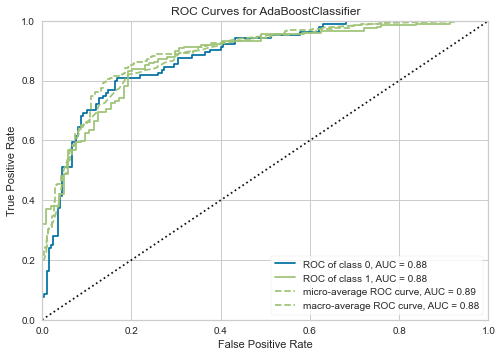

In [50]:
plot_model(boosted_lr, 'auc')

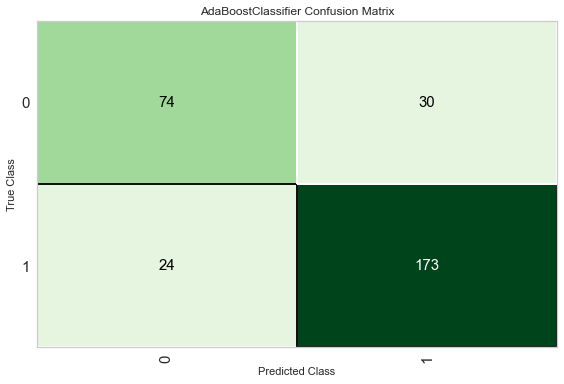

In [99]:
plot_model(boosted_lr, 'confusion_matrix')

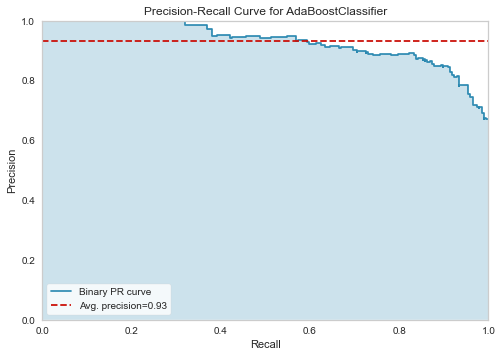

In [100]:
plot_model(boosted_lr, 'pr')

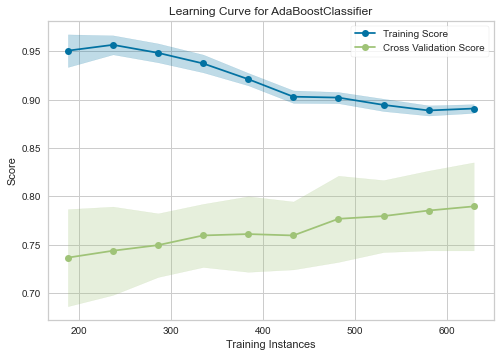

In [103]:
plot_model(boosted_lr, 'learning')

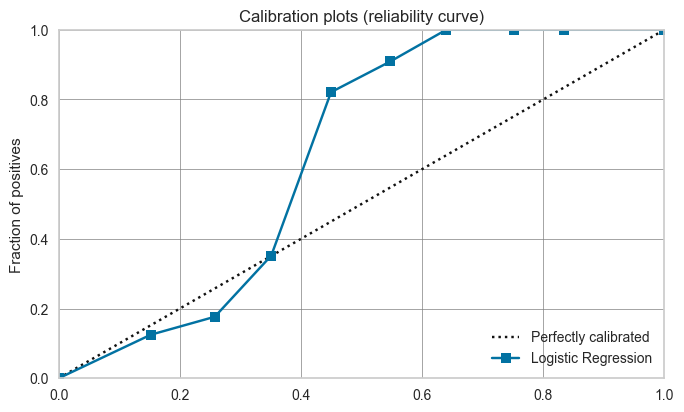

In [104]:
plot_model(boosted_lr, 'calibration')

In [112]:
lr_final = finalize_model(tuned_lr)

In [113]:
predictions = predict_model(lr_final)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9236,0.9732,0.9695,0.9183,0.9432,0.8267,0.8296


In [114]:
predictions

,drawer,site,bud,awhile,fitting,wish,sensory,update,stay,affect,...,porridge,help,straightforward,lucky,wow,stick,strava,real_review,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7159
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.7031
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5627
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5016
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7767
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7081
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6613
299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8638


In [86]:
predictions.dtypes

drawer         float32
site           float32
bud            float32
awhile         float32
fitting        float32
                ...   
stick          float32
strava         float32
real_review     object
Label            int32
Score          float64
Length: 1253, dtype: object

In [91]:
predictions['real_review'] = pd.to_numeric(predictions['real_review'])

In [92]:
wrong = predictions.loc[(predictions['Label'] - predictions['real_review'])!=0]

In [93]:
wrong

,drawer,site,bud,awhile,fitting,wish,sensory,update,stay,affect,...,porridge,help,straightforward,lucky,wow,stick,strava,real_review,Label,Score
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5024
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5010
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5004
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5007
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5002
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5004
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.5002
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.5006
115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5030
119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.5003


# Conclusion

The relatively high test AUC score of 0.9732 and F1 score of 0.9432 attained indicated that tuned Logistic Regression model is quite successful in predicting whether review is legitimate or not based on the text.

## Recommendations

1. Tighten Incentives Requirements

Deploy model to only reward incentives to legitimate reviews

2. Include Other Scoring Metrics for Reviews

Delivery speed and customer service do matter

3. Increase Time Given for Reviews

Some products like skincare take a while for results to show 


## Future Outlook

1. Deep Learning
2. Textual Sentiment Analysis
3. Model Deployment to Lazada
4. More Training Data

In [ ]:
#exporting cleaned collected data
train2.to_csv('train_rnn', index=False)
